In [1]:
%matplotlib notebook
%matplotlib notebook
import ipykernel
import matplotlib
import numpy as np
import scipy.interpolate as sp
import pylab
import matplotlib.pyplot as plt
import math
import csv

In [2]:
def catmull_rom_one_point(x, v0, v1, v2, v3):
    """Computes interpolated y-coord for given x-coord using Catmull-Rom.
    Computes an interpolated y-coordinate for the given x-coordinate between
    the support points v1 and v2. The neighboring support points v0 and v3 are
    used by Catmull-Rom to ensure a smooth transition between the spline
    segments.
    Args:
        x: the x-coord, for which the y-coord is needed
        v0: 1st support point
        v1: 2nd support point
        v2: 3rd support point
        v3: 4th support point
    """
    c1 = 1. * v1
    c2 = -.5 * v0 + .5 * v2
    c3 = 1. * v0 + -2.5 * v1 + 2. * v2 -.5 * v3
    c4 = -.5 * v0 + 1.5 * v1 + -1.5 * v2 + .5 * v3
    return (((c4 * x + c3) * x + c2) * x + c1)

In [3]:
def catmull_rom(p_x, p_y, res):
    """Computes Catmull-Rom Spline for given support points and resolution.
    Args:
        p_x: array of x-coords
        p_y: array of y-coords
        res: resolution of a segment (including the start point, but not the
            endpoint of the segment)
    """
    # create arrays for spline points
    x_intpol = np.empty(res*(len(p_x)-1) + 1)
    y_intpol = np.empty(res*(len(p_x)-1) + 1)

    # set the last x- and y-coord, the others will be set in the loop
    x_intpol[-1] = p_x[-1]
    y_intpol[-1] = p_y[-1]

    # loop over segments (we have n-1 segments for n points)
    for i in range(len(p_x)-1):
        # set x-coords
        x_intpol[i*res:(i+1)*res] = np.linspace(
            p_x[i], p_x[i+1], res, endpoint=False)
        if i == 0:
            # need to estimate an additional support point before the first
            y_intpol[:res] = np.array([
                catmull_rom_one_point(
                    x,
                    p_y[0] - (p_y[1] - p_y[0]), # estimated start point,
                    p_y[0],
                    p_y[1],
                    p_y[2])
                for x in np.linspace(0.,1.,res, endpoint=False)])
        elif i == len(p_x) - 2:
            # need to estimate an additional support point after the last
            y_intpol[i*res:-1] = np.array([
                catmull_rom_one_point(
                    x,
                    p_y[i-1],
                    p_y[i],
                    p_y[i+1],
                    p_y[i+1] + (p_y[i+1] - p_y[i]) # estimated end point
                ) for x in np.linspace(0.,1.,res, endpoint=False)])
        else:
            y_intpol[i*res:(i+1)*res] = np.array([
                catmull_rom_one_point(
                    x,
                    p_y[i-1],
                    p_y[i],
                    p_y[i+1],
                    p_y[i+2]) for x in np.linspace(0.,1.,res, endpoint=False)])


    return (x_intpol, y_intpol)

<IPython.core.display.Javascript object>


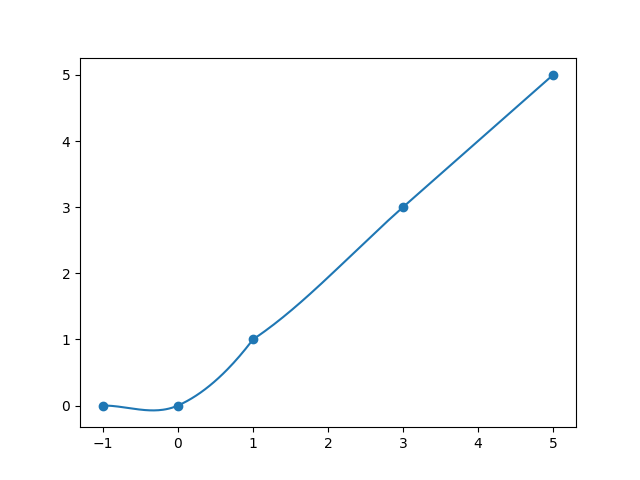

In [4]:
import matplotlib.pyplot as plt

'''
Source: https://github.com/vmichals/python-algos/blob/master/catmull_rom_spline.py
'''
    
# set the resolution (number of interpolated points between each pair of
# points, including the start point, but excluding the endpoint of each
# interval)
res = 50

# # generate some random support points
# p_x = np.arange(-10,11, dtype='float32')
# p_y = np.zeros_like(p_x)
# for i in range(len(p_x)):
#     p_y[i] = np.random.rand()*3. - 1.5

p_x = np.array([-1, 0,1, 3, 5])
p_y = np.array([0, 0, 1, 3, 5])

# do the catmull-rom
x_intpol, y_intpol = catmull_rom(p_x, p_y, res)

# fancy plotting
plt.figure()
plt.scatter(p_x, p_y)
plt.plot(x_intpol, y_intpol)
plt.show()

In [5]:
def CatmullRomSpline(P0, P1, P2, P3, a, nPoints=100):
    """
    P0, P1, P2, and P3 should be (x,y) point pairs that define the Catmull-Rom spline.
    nPoints is the number of points to include in this curve segment.
    """
    # Convert the points to numpy so that we can do array multiplication
    P0, P1, P2, P3 = map(np.array, [P0, P1, P2, P3])

    # Calculate t0 to t4
    alpha = a
    
    def tj(ti, Pi, Pj):
        xi, yi = Pi
        xj, yj = Pj
        return ( ( (xj-xi)**2 + (yj-yi)**2 )**0.5 )**alpha + ti

    t0 = 0
    t1 = tj(t0, P0, P1)
    t2 = tj(t1, P1, P2)
    t3 = tj(t2, P2, P3)

    # Only calculate points between P1 and P2
    t = np.linspace(t1,t2,nPoints)

    # Reshape so that we can multiply by the points P0 to P3
    # and get a point for each value of t.
    t = t.reshape(len(t),1)

    A1 = (t1-t)/(t1-t0)*P0 + (t-t0)/(t1-t0)*P1
    A2 = (t2-t)/(t2-t1)*P1 + (t-t1)/(t2-t1)*P2
    A3 = (t3-t)/(t3-t2)*P2 + (t-t2)/(t3-t2)*P3

    B1 = (t2-t)/(t2-t0)*A1 + (t-t0)/(t2-t0)*A2
    B2 = (t3-t)/(t3-t1)*A2 + (t-t1)/(t3-t1)*A3

    C  = (t2-t)/(t2-t1)*B1 + (t-t1)/(t2-t1)*B2
    return C

In [6]:
def CatmullRomChain(P,alpha):
    """
    Calculate Catmull Rom for a chain of points and return the combined curve.
    """
    sz = len(P)

    # The curve C will contain an array of (x,y) points.
    C = []
    for i in range(sz-3):
        c = CatmullRomSpline(P[i], P[i+1], P[i+2], P[i+3],alpha)
        C.extend(c)

    return C

<IPython.core.display.Javascript object>


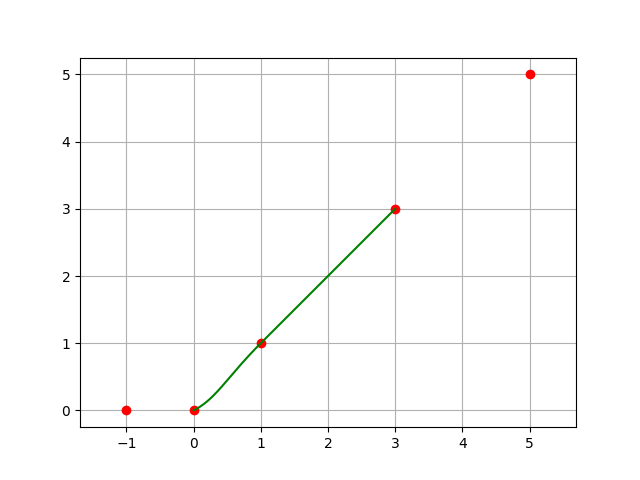

In [7]:
''' 
Source: https://math.stackexchange.com/questions/1789112/cubic-spline-interpolation-results 
'''

plt.figure()

priorPoint = [-1,0]
origin = [0,0]
spline = []
spline.append([1,1])
spline.append([3,3])
spline.append([5,5])

for i in range(0, len(spline), 3):
    a=0.
    Points=np.array([np.array([priorPoint[0],priorPoint[1]]),
                  np.array([origin[0],origin[1]]),
                  np.array([spline[i][0],spline[i][1]]),
                  np.array([spline[i+1][0],spline[i+1][1]]),
                  np.array([spline[i+2][0],spline[i+2][1]])  ])

    # Calculate the Catmull-Rom splines through the points
    c = CatmullRomChain(Points,a)

    # Convert the Catmull-Rom curve points into x and y arrays and plot
    x,y = zip(*c)
    plt.plot(x,y,c='green',zorder=10)

    # Plot the control points
    px, py = zip(*Points)
    plt.plot(px,py,'or')

#     a=0.5
#     c = CatmullRomChain(Points,a)
#     x,y = zip(*c)
#     plt.plot(x,y,c='blue')

#     a=1.
#     c = CatmullRomChain(Points,a)
#     x,y = zip(*c)
#     plt.plot(x,y,c='red')

    plt.axis('equal')
    plt.grid(b=True)
    plt.show()